#### Compute adjacency complex to track persistence

In [43]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle as pickle
from pylab import *
import os    
import numpy as np

import warnings

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import io
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageChops, ImageFont
import shapely.geometry as geom
from shapely.ops import unary_union
import gudhi

import invr

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [18]:
# get the list of folders in a location
def get_folders(location):
    return [name for name in os.listdir(location) if os.path.isdir(os.path.join(location, name))]

In [19]:
states = get_folders('/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/data/processed data/svi with hepvu/2018/SVI2018 census tracts with death rate HepVu-5 classes')

In [20]:
print('Number of states:', len(states))
print(states)

Number of states: 50
['VT', 'VA', 'SD', 'SC', 'UT', 'GA', 'MS', 'MT', 'MO', 'MA', 'AK', 'KY', 'AL', 'NH', 'MN', 'MI', 'OK', 'IN', 'CO', 'CA', 'IA', 'CT', 'FL', 'WV', 'RI', 'WY', 'TX', 'PA', 'NC', 'ND', 'NM', 'NJ', 'ME', 'AR', 'NV', 'MD', 'KS', 'NE', 'HI', 'DE', 'AZ', 'NY', 'ID', 'OH', 'OR', 'IL', 'LA', 'WI', 'WA', 'TN']


In [21]:
for state in states:
    # create a folder for each state if it does not exist
    os.makedirs(f"/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/data/processed data/selected coordinates for each state - percentiles(below 90th)- all variables/{state}", exist_ok=True)
print('Done creating folders for each state')

Done creating folders for each state


In [30]:
selected_variables = ['EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','NOD_Rate']
selected_variables_without_y = ['EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']

# selected_variables_for_state_with_geo = ['FIPS','EP_DISABL', 'EP_NOHSDP', 'EP_PCI', 'EP_MOBILE', 'EP_POV','NOD_Rate','geometry']
# selected_variables_for_state = ['EP_DISABL', 'EP_NOHSDP', 'EP_PCI', 'EP_MOBILE', 'EP_POV']
# selected_variables_tn_with_od = ['EP_DISABL', 'EP_NOHSDP', 'EP_PCI', 'EP_MOBILE', 'EP_POV','NOD_Rate']

selected_variables_for_state_with_geo = ['FIPS','EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','NOD_Rate','geometry']
selected_variables_for_state = ['EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']
selected_variables_tn_with_od = ['EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','NOD_Rate']

selected_variables_with_censusinfo = ['FIPS','STCNTY','EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','NOD_Rate','geometry']


In [37]:
# def generate_adjacent_counties(dataframe,filtration_threshold,variable_name):
def generate_adjacent_counties(dataframe,variable_name):


    filtered_df = dataframe
    # filtered_df = dataframe[dataframe[variable_name] < filtration_threshold]

    # Perform a spatial join to find adjacent precincts
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')

    # Filter the results to include only the adjacent states
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')

    # Group the resulting dataframe by the original precinct Name and create a list of adjacent precinct Name
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()

    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)

    adjacencies_list = adjacent_counties['adjacent'].tolist()
    county_list = adjacent_counties['county'].tolist()

    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county',right_on='sortedID', how='left')
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

    return adjacencies_list,merged_df,county_list

In [24]:
def form_simplicial_complex(adjacent_county_list,county_list):
    max_dimension = 3

    V = []
    V = invr.incremental_vr(V, adjacent_county_list, max_dimension,county_list)

    return V

In [25]:
def plot_simplicial_complex(dataframe,V):

    #city centroids
    city_coordinates = {city.sortedID: np.array((city.geometry.centroid.x, city.geometry.centroid.y)) for _, city in dataframe.iterrows()}

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_axis_off() 

    # Plot the "wyoming_svi" DataFrame
    dataframe.plot(ax=ax, edgecolor='black', linewidth=0.3, color="white")

    # Plot the centroid of the large square with values
    # for i, row in dataframe.iterrows():
    #     centroid = row['geometry'].centroid
    #     # text_to_display = f"FIPS: {row['FIPS']}\nFilteration: {row['EP_SNGPNT']}"
    #     plt.text(centroid.x, centroid.y, str(row['FIPS']), fontsize=8, ha='center', color="black")
    #     # plt.text(centroid.x, centroid.y, text_to_display, fontsize=10, ha='center', color="black")

    for edge_or_traingle in V:

        
        if len(edge_or_traingle) == 2:
            # Plot an edge
            ax.plot(*zip(*[city_coordinates[vertex] for vertex in edge_or_traingle]), color='red', linewidth=1)
            # img = fig2img(fig)
            # list_gif.append(img)
        elif len(edge_or_traingle) == 3:
            # Plot a triangle
            ax.add_patch(plt.Polygon([city_coordinates[vertex] for vertex in edge_or_traingle], color='green', alpha=0.2))
            # img = fig2img(fig)
            # list_gif.append(img)
    # plt.show()
    plt.close()

In [49]:
for var in selected_variables_without_y:
    # create a folder for each state if it does not exist
    os.makedirs(f"/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/results/test/{var}", exist_ok=True)
print('Done creating folders for each state')

Done creating folders for each state


In [64]:
# create an empty dataframe with the columns county, H0, H1, No Persistence
columns = ['county','census_c','variable','H0','H1','No Persistence']
summary_df = pd.DataFrame(columns=columns)


In [65]:
for state in states:

    print('Processing:', state)

    # Initialize dictionaries to store the percentiles
    


    svi_od = gpd.read_file(f'/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/data/processed data/svi with hepvu/2018/SVI2018 census tracts with death rate HepVu-5 classes/{state}/{state}.shp')
    
    # Drop -999 in selected_variables_for_state
    for variable in selected_variables_for_state:
        svi_od = svi_od[svi_od[variable] != -999]

    

    svi_od_filtered_state = svi_od[selected_variables_with_censusinfo]

    #reset index
    svi_od_filtered_state = svi_od_filtered_state.reset_index(drop=True)

    # get the uniques counties
    unique_county_stcnty = svi_od_filtered_state['STCNTY'].unique()

    # print('Number of counties:', len(unique_county_stcnty))


    # percentiles_50 = {}
    # percentiles_75 = {}
    # percentiles_90 = {}

    for county_stcnty in unique_county_stcnty:
        # print('Processing:', county_stcnty)

        # Filter the dataframe to include only the current county
        county_svi_df = svi_od_filtered_state[svi_od_filtered_state['STCNTY'] == county_stcnty]

        # print('Number of rows:', len(county_svi_df))

        # # Calculate the percentiles for each variable
            # for variable in selected_variables_for_state:
            #     percentiles_50[variable] = svi_od[variable].quantile(0.5)
            #     percentiles_75[variable] = svi_od[variable].quantile(0.75)
            #     percentiles_90[variable] = svi_od[variable].quantile(0.9)

        # need to change here later

        for variable_name in selected_variables_without_y:
            
            # print('Processing:', variable_name)

            # Sorting based on the variable and selecting only the FIPS and the variable columns is important
            # Also we need to keep  the dataframe sorted based on the variable


            # Cahanged FIPS into STCNTY
            df_one_variable = county_svi_df[['STCNTY',variable_name, 'geometry']]

            # # Sorting the DataFrame based on the 'rate' column
            df_one_variable = df_one_variable.sort_values(by=variable_name)
            df_one_variable['sortedID'] = range(len(df_one_variable))

            # Convert the DataFrame to a GeoDataFrame
            df_one_variable = gpd.GeoDataFrame(df_one_variable, geometry='geometry')
            df_one_variable.crs = "EPSG:3395"  # This is a commonly used projected CRS

            # Heter thresho;d removed from original adj method - change it later
            adjacencies_list,adjacent_counties_df,county_list = generate_adjacent_counties(df_one_variable,variable_name)

            # create a dictionary adjacent_counties_df column county as key and column adjacent as value(to avoid NULL adjacencies error)
            adjacent_counties_dict = dict(zip(adjacent_counties_df['county'],adjacent_counties_df['adjacent']))

            # this take only counties that have adjacent counties
            county_list = adjacent_counties_df['county'].tolist()

            simplices = form_simplicial_complex(adjacent_counties_dict,county_list)

            #NEW code from here

            st = gudhi.SimplexTree()
            st.set_dimension(2)

            for simplex in simplices:
                if len(simplex) == 1:
                    st.insert([simplex[0]], filtration=0.0)
                    # print("Simplex: ",simplex)
                    # print("Filteration Value: ",0.0)
            
            for simplex in simplices:
                if len(simplex) == 2:
                    last_simplex = simplex[-1]
                    filteration_value = df_one_variable.loc[df_one_variable['sortedID'] == last_simplex, variable_name].values[0]
                    st.insert(simplex, filtration=filteration_value)

                    # print("Simplex: ",simplex)
                    # print("Filteration Value: ",filteration_value)

            for simplex in simplices:
                if len(simplex) == 3:
                    last_simplex = simplex[-1]
                    filteration_value = df_one_variable.loc[df_one_variable['sortedID'] == last_simplex, variable_name].values[0]
                    st.insert(simplex, filtration=filteration_value)

                    # print("Simplex: ",simplex)
                    # print("Filteration Value: ",filteration_value)

            #Compute persistence
            st.compute_persistence()

            persistence = st.persistence()

            if len(persistence) > 0:
                # gudhi.plot_persistence_diagram(persistence)

                # plt.savefig(f'/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/results/test/{variable_name}/persistence_diagram_{county_stcnty}.png')
                # plt.close()
                intervals_dim0 = st.persistence_intervals_in_dimension(0)
                intervals_dim1 = st.persistence_intervals_in_dimension(1)

                # add to summary_df
                new_row = {'county': county_stcnty,'census_c':len(df_one_variable),'variable': variable_name , 'H0': len(intervals_dim0), 'H1':len(intervals_dim1) , 'No Persistence': "False"}
                summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)

            else:
                new_row = {'county': county_stcnty,'census_c':len(df_one_variable),'variable': variable_name , 'H0': NAN, 'H1':NAN , 'No Persistence': "True"}
                summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)


        # break
    # break


print('All states processed.')

Processing: VT
Processing: VA
Processing: SD
Processing: SC
Processing: UT
Processing: GA
Processing: MS
Processing: MT
Processing: MO
Processing: MA
Processing: AK
Processing: KY
Processing: AL
Processing: NH
Processing: MN
Processing: MI
Processing: OK
Processing: IN
Processing: CO
Processing: CA
Processing: IA
Processing: CT
Processing: FL
Processing: WV
Processing: RI
Processing: WY
Processing: TX
Processing: PA
Processing: NC
Processing: ND
Processing: NM
Processing: NJ
Processing: ME
Processing: AR
Processing: NV
Processing: MD
Processing: KS
Processing: NE
Processing: HI
Processing: DE
Processing: AZ
Processing: NY
Processing: ID
Processing: OH
Processing: OR
Processing: IL
Processing: LA
Processing: WI
Processing: WA
Processing: TN
All states processed.


In [66]:
summary_df

,county,census_c,variable,H0,H1,No Persistence
0,50001,10,EP_POV,10,1,False
1,50001,10,EP_UNEMP,10,2,False
2,50001,10,EP_PCI,10,0,False
3,50001,10,EP_NOHSDP,10,2,False
4,50001,10,EP_UNINSUR,10,0,False
...,...,...,...,...,...,...
50219,47181,4,EP_MUNIT,4,0,False
50220,47181,4,EP_MOBILE,4,0,False
50221,47181,4,EP_CROWD,4,0,False
50222,47181,4,EP_NOVEH,4,0,False


In [71]:
# GET THE MAXIMUM H1 VALUE
max_h1 = summary_df['H1'].max()

max_h1

323

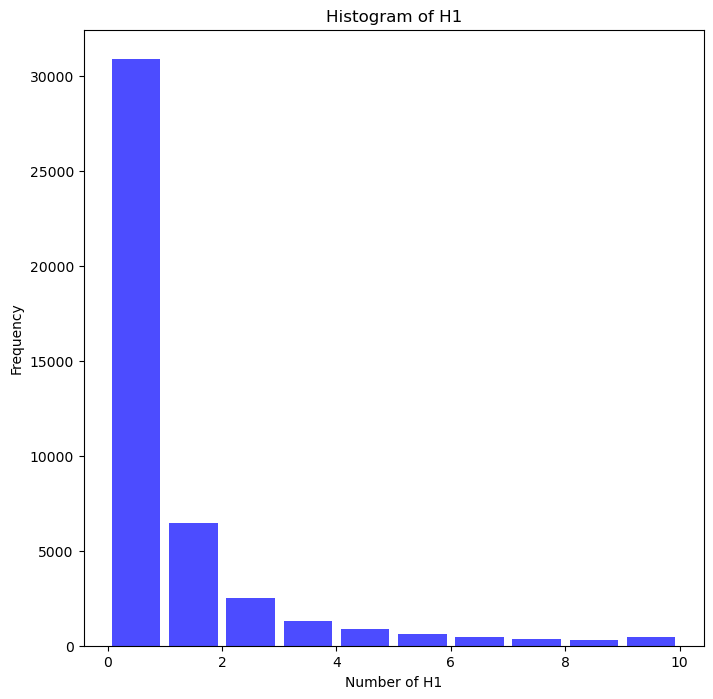

In [75]:
# plot H1 histogram using matplotlib and only H1 between 0-60

summary_df__ = summary_df[summary_df['H1'] <= 10]

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(summary_df__['H1'], bins=10, color='blue', alpha=0.7, rwidth=0.85)
ax.set_xlabel('Number of H1')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of H1')
plt.show()



In [84]:
# get the unique count in the summary_df H1
summary_df[summary_df['variable'] == 'EP_POV']['H1'].value_counts()


H1
0      1905
1       447
2       155
3        69
4        58
5        40
7        23
8        22
6        22
9        16
11       14
12       13
15       12
10        9
13        8
20        7
17        7
18        6
35        6
21        5
23        4
22        3
19        3
25        3
24        3
16        3
46        2
37        2
47        2
28        2
66        2
27        2
30        2
41        1
71        1
26        1
91        1
44        1
86        1
72        1
156       1
119       1
62        1
59        1
29        1
34        1
40        1
51        1
78        1
49        1
307       1
38        1
14        1
39        1
Name: count, dtype: int64

In [81]:
A

[30890,
 6462,
 2531,
 1290,
 875,
 625,
 469,
 360,
 298,
 237,
 213,
 190,
 173,
 130,
 127,
 119,
 106,
 103,
 92,
 85,
 71,
 64,
 64,
 53,
 47,
 42,
 37,
 31,
 29,
 27,
 24,
 23,
 21,
 20,
 20,
 19,
 19,
 17,
 17,
 16,
 15,
 15,
 14,
 13,
 13,
 12,
 11,
 10,
 9,
 9,
 9,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [85]:
# save the summary_df to a csv file

summary_df.to_csv('/Users/h6x/ORNL/git/modeling-ideas/overdose modeling for entire country/results/test/summary_df_full_data.csv', index=False)